# 텍스트 요약하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 데이터를 가져옵니다.

In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
data.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
58800,58801,B000MIFS3Y,A2WFGEBEO19WX9,DreadWolf,0,0,5,1204502400,As good as the cans,"If you like the canned version, these are just..."
51182,51183,B001J5QHYS,A1XII9T8QIGNK4,Honest Ade Junkie,0,0,5,1346284800,Best ever bottled drink,I have been buying this drink for a couple of ...
93731,93732,B001EO5S58,A32B402Z0ZZ7VH,Nakkun,0,0,5,1327968000,Kids love this,This is the most popular Glutino Breakfast Bar...
82438,82439,B000LKYOAG,A21YNHY2MN83CP,D Taylor,0,0,4,1295827200,Great Tea...But the Cost,This is a great tasting tea. I use one bag fo...
28388,28389,B007OXJMD2,A1YNN51RNUCCUA,Jennilee R. Benda,0,0,2,1342915200,"It's okay, but not really worth buying.",I had some of this in a sampler pack. It real...


### 필요한 데이터만을 남깁니다.

In [3]:
data = data[['Text','Summary']]
data.sample(5)

,Text,Summary
17506,I really like this blend. I've had a hard tim...,"Strong, but not bitter"
67738,"I buy mostly for vending, so the size of the b...",glad to find them in 1 oz size
53941,I have had trouble getting to sleep or staying...,Relaxxxxxx.........
7020,These cups work for the most part except for t...,Good Start but Could Be Better.
43003,"The chocolate taste was good (not great), and ...","Fine, But Not Spectacular"


## 데이터를 전처리합니다.
* 중복을 제거합니다.
* NULL값을 제거합니다.
* 텍스트를 정규화 합니다.
* 훈련 데이터와 테스트 데이터로 분리합니다.
* 정수로 인코딩합니다.
* 모든 문장의 길이를 통일시켜줍니다.(zero padding)

In [4]:
#중복 제거
print("data의 샘플 수 :",data.shape[0])
print("Text 열에서 중복을 제외한 유일한 샘플 수 :",data['Text'].nunique())
print("Summary 열에서 중복을 제외한 유일한 샘플 수 :",data['Summary'].nunique())

data의 샘플 수 : 100000
Text 열에서 중복을 제외한 유일한 샘플 수 : 88426
Summary 열에서 중복을 제외한 유일한 샘플 수 : 72348


* Summary의 중복은 있을 수 있지만 Text의 중복은 중복 샘플이므로 제거합니다.

In [5]:
data.drop_duplicates(subset = ['Text'],inplace = True)
print("data의 샘플 수 :",data.shape[0])

data의 샘플 수 : 88426


In [6]:
# 결측치 제거
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [7]:
data.dropna(axis=0,inplace = True)
print("data의 샘플 수 :",data.shape[0])

data의 샘플 수 : 88425


### 텍스트 정규화와 불용어 제거
* 모델의 연산량을 줄이기 위해 정규화 시 같은 의미의 다른 표현들을 서로 통일 시켜줍니다.
* 예를 들어 it'll은 it will과 같은 말이기 때문에 같은 표현으로 간주하도록 합니다.

In [8]:
# 표현을 통일시키기 위한 딕셔너리 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 불용어를 제거합니다.
* 텍스트에는 자주 등장하지만 자연어 처리를 할 때에는 실질적인 도움이 되지않는 언어를 불용어라고 합니다.
* 아래에서 NLTK에서 제공하는 불용어 리스트를 참조해, 불용어를 제거합니다.

In [9]:
# 사전에 정의된 불용어 리스트를 확인합니다.
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english')[:20])

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [10]:
# 데이터 전처리를 위한 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

In [12]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

* 상대적으로 짧은 Summary에는 불용어가 남아있는것이 좋습니다.

In [13]:
print("Text 전처리 후 결과 :",clean_text[:3])
print("Summary 전처리 후 결과 :",clean_summary[:3])

Text 전처리 후 결과 : ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch']
Summary 전처리 후 결과 : ['good quality dog food', 'not as advertised', 'delight says it all']


In [14]:
#전처리된 데이터로 대체해줍니다.
data['Text'] = clean_text
data['Summary'] = clean_summary
#비어있는 값을 NULL로 변환합니다.
data.replace('',np.nan,inplace=True)
#NULL값이 생겼는지 확인해보겠습니다.
data.isnull().sum()
#NULL을 제거합니다.
data.dropna(axis=0,inplace=True)
print('전체 샘플 수 :',data.shape[0])

전체 샘플 수 : 88355


### 샘플의 최대 길이 결정하기
* 데이터 시각화를 통해 최대길이를 어떻게 결정할지 생각해봅시다.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


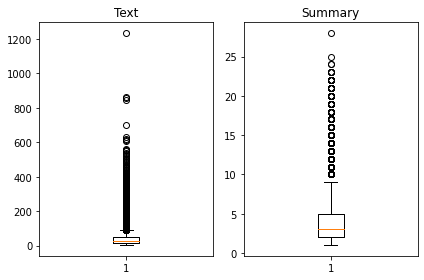

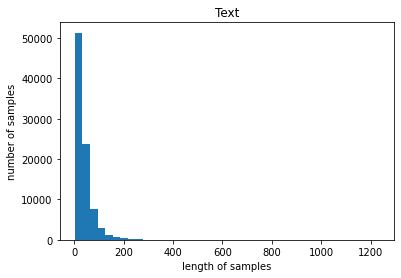

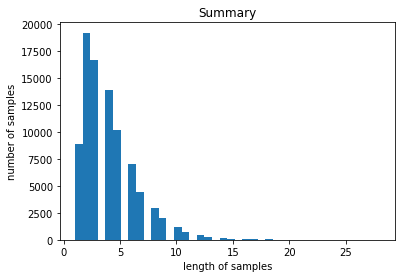

In [15]:
# 길이 분포 시각화
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* Text의 최소길이는 2, 최대길이는 1235로 차이가 매우 크게 나지만 평균길이는 38이며 시각화된 그래프를 보면 대체적으로 100자 내외의 길이를 가집니다.
* Summary의 최소길이는 1, 최대길이는 28이며 평균길이는 4로 상대적으로 길이가 짧습니다. 그래프를 보아도 대체적으로 길이가 10 이하인 것을 볼 수 있습니다.

In [16]:
# 적절한 최대 길이를 결정합니다.
text_max_len = 50
summary_max_len = 8

In [17]:
#최대길이에 맞는 비율
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len,data['Text'])
below_threshold_len(summary_max_len,data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


* 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, 이 대신 이 길이보다 길면 제외하는 방식으로 데이터를 정제하도록 합니다.

In [19]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


### 시작 토큰과 종료 토큰 추가하기
* seq2seq 훈련을 위해 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다.
* 각각 decoder_input, decoder_target 컬럼을 Summary 컬럼으로부터 만들도록 합니다.

In [20]:
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [21]:
# 테스트데이터와 훈련데이터를 분리하는 함수를 정의합니다.
def train_test_split(dt,ratio = 0.2):
    #데이터프레임의 컬럼명을 리스트로 받는다.
    col_list = list(dt.columns)
    #인코더의 입력
    encoder_input = np.array(dt[col_list[0]])# text
    #디코더의 입력
    decoder_input = np.array(dt[col_list[2]])# decoder_input
    #디코더의 레이블
    decoder_target = np.array(dt[col_list[3]])# decoder_target
    
    #데이터를 랜덤하게 섞어줍니다.
    indices = np.arange(encoder_input.shape[0])
    np.random.shuffle(indices)
    
    encoder_input = encoder_input[indices]
    decoder_input = decoder_input[indices]
    decoder_target = decoder_target[indices]
    n_of_val = int(len(encoder_input)*ratio)
    
    encoder_input_train = encoder_input[:-n_of_val]
    decoder_input_train = decoder_input[:-n_of_val]
    decoder_target_train = decoder_target[:-n_of_val]
    
    encoder_input_test = encoder_input[-n_of_val:]
    decoder_input_test = decoder_input[-n_of_val:]
    decoder_target_test = decoder_target[-n_of_val:]
    
    return encoder_input_train,decoder_input_train,decoder_target_train,encoder_input_test,decoder_input_test,decoder_target_test

In [22]:
#테스트 데이터와 훈련 데이터를 분리합니다.
encoder_input_train,decoder_input_train,decoder_target_train,encoder_input_test,decoder_input_test,decoder_target_test = train_test_split(data)

In [23]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


### 정수 인코딩
* 기계가 텍스트를 숫자로 처리할 수 있도록 모든 데이터를 정수로 바꿔주어야 합니다.
* 이 과정을 단어 집합을 만든다고 표현합니다.

In [24]:
#희귀 단어 등장 비율을 계산하는 함수
def rare_voca(token,threshold = 7):
    #전체 단어의 수
    total_cnt = len(token.word_index)
    #희귀 단어의 수
    rare_cnt = 0
    #전체 단어 빈도 수
    total_freq = 0
    #희귀 단어 빈도 수
    rare_freq = 0
    
    for key,value in token.word_counts.items():
        total_freq = total_freq+value
        
        if(value < threshold):
            rare_cnt = rare_cnt+1
            rare_freq = rare_freq+value
    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [25]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [26]:
rare_voca(src_tokenizer)

단어 집합(vocabulary)의 크기 : 31956
등장 빈도가 6번 이하인 희귀 단어의 수: 23731
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8225
단어 집합에서 희귀 단어의 비율: 74.26148454124422
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3800599039774477


* 등장 빈도가 6회 이하인 단어의 비율이 약 74퍼센트나 됩니다.
* 따라서 희귀 단어들은 훈련셋에서 제외하도록 하겠습니다.
* 토큰화는 빈도순으로 결정되기에 약 8천개 이후의 데이터를 모두 잘라줍니다.

In [27]:
src_vocab = 8000

In [28]:
#단어 사전의 크기를 제한
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [29]:
#텍스트 데이터를 정수 시퀀스로 변환합니다.
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [30]:
#변환이 잘 되었는지 확인해봅니다.
print(encoder_input_train[:3])
print(encoder_input_test[:3])

[[138, 619, 232, 57, 1504, 60, 1324, 212, 91, 2043, 143, 836, 611, 780, 205, 2069, 278, 551, 1471, 14, 203, 329, 3204, 205, 2069, 908, 117, 2344, 12, 1, 4, 20, 1504, 60, 23, 42, 455, 24, 42, 390, 63, 60, 203, 1430, 1, 265, 54], [1630, 106, 1272, 3152, 6, 54, 4, 22, 4, 332, 100, 501, 542], [7669, 924, 239, 1443, 6, 7185, 59, 7670, 69, 139, 16, 33, 24, 13, 108, 162, 51, 564, 514, 103, 222, 14, 1, 1137, 139, 57, 3153, 1085, 2442, 102, 495, 410, 4, 16]]
[[6, 111, 16, 69, 70, 291, 88, 2126], [115, 333, 8, 535, 8, 747, 8, 6, 131, 8, 6, 194], [47, 1332, 12, 191, 269, 4, 179, 1665, 226, 110, 182, 210]]


### 디코더 레이블 역시 똑같이 처리합니다.

In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
rare_voca(tar_tokenizer,6)

단어 집합(vocabulary)의 크기 : 10450
등장 빈도가 5번 이하인 희귀 단어의 수: 8067
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2383
단어 집합에서 희귀 단어의 비율: 77.19617224880383
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.857654096094467


In [33]:
tar_vocab = 2000

In [34]:
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [35]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [36]:
#변환이 잘되었는지 확인합니다.
print('input')
print('input ',decoder_input_train[:3])
print('target')
print('decoder ',decoder_target_train[:3])

input
input  [[1, 582, 250, 15, 45, 108], [1, 62, 4, 8, 1649], [1, 5, 7, 954, 32]]
target
decoder  [[582, 250, 15, 45, 108, 2], [62, 4, 8, 1649, 2], [5, 7, 954, 32, 2]]


* sostoken과 eostoken이 각각 1,2로 매핑되어있고 잘 문장의 앞 뒤로 추가가 되어있는 것 역시 볼 수 있습니다. 

### 한가지 점검할 점
* 저희가 만든 단어사전에서 등장 빈도수가 낮은 단어들을 모두 삭제했습니다.
* 만약 상대적으로 빈도수가 낮은 단어만으로 구성된 샘플의 경우 빈 샘플이 되었을 가능성이 있습니다.
* 이 현상은 평균 길이가 작은 Summary에서 발생할 가능성이 높습니다.
* 비어버린 문장들을 모두 제거하도록 합시다.

In [37]:
#비어버린 문장은 시작토큰만 남아있을 것입니다. 따라서 길이 1의 문장을 모두 제거하도록 합니다.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1237
삭제할 테스트 데이터의 개수 : 358
훈련 데이터의 개수 : 51418
훈련 레이블의 개수 : 51418
테스트 데이터의 개수 : 12805
테스트 레이블의 개수 : 12805


### zero padding하기
* 모든 문장의 길이를 통일시키기 위해 빈 공간에 숫자 0을 삽입합니다.

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

#### 모든 전처리가 완료되었습니다.

## 모델 설계

### 모듈 호출

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

In [40]:
embedding_dim = 128
hidden_size = 256

### 인코더 설계

In [41]:
# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# 레이어를 선언하고 해당 레이어를 상위 레이어와 연결합니다.
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 레이어를 상위 레이어와 연결하는 동작이 있는데 Linked-List처럼 encoder_inputs만 있어도 인코더 전체를 가지고 다닐 수 있습니다.


* 인코더의 LSTM은 3개의 층으로 구성하여 모델의 복잡도를 높였습니다. hidden state의 크기를 늘리는 것이 LSTM 하나의 용량을 늘리는 것이라면 3개의 층을 이용하는 것은 모델의 용량을 늘려주는 것으로 볼 수 있습니다.  
최종적으로 출력된 벡터는 디코더로 보내지게 됩니다.


* LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용합니다.  
일반적인 dropout은 레이어의 weight를 랜덤으로 생략해 모델의 과적합을 해결해주는 방법인 반면, recurrent dropout은 dropout을 레이어가 아닌 time step마다 수행합니다.  
즉, time step의 입력을 랜덤으로 생략해주게 됩니다.

### 디코더 설계

In [42]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

* 인코더와 거의 비슷하지만 디코더의 LSTM에서 initial_state의 인자값으로 인코더의 hidden state와 cell state를 넣어주어야 합니다.

In [43]:
#디코더의 출력층 정의
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

In [44]:
#모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

* 디코더의 출력층에서는 tar_vocab의 선택지중 하나의 단어를 선택하는 다중 클래스 분류문제를 풀어야해 Dense의 인자로 tar_vocab을 주고, activation으로 softmax를 사용합니다.

### 어텐션 매커니즘
* 현재 모델의 디코더의 출력층의 설계를 살짝 바꿔서 성능을 높힐 수 있는 방법입니다.
* tf에 이미 구현된 어텐션 함수를 가져와 디코더를 새로 설계합시다.

In [45]:
from tensorflow.keras.layers import AdditiveAttention

In [46]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델을 새로 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련
* EarlyStopping을 이용해 모델 훈련을 최적점에서 종료되도록 합니다.
* 그 후, 훈련과정을 시각화 해보도록 합시다.

In [47]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [48]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 140s 655ms/step - loss: 2.7071 - val_loss: 2.4260
Epoch 2/50
201/201 [==============================] - 130s 648ms/step - loss: 2.3801 - val_loss: 2.2887
Epoch 3/50
201/201 [==============================] - 130s 646ms/step - loss: 2.2210 - val_loss: 2.1353
Epoch 4/50
201/201 [==============================] - 130s 645ms/step - loss: 2.0980 - val_loss: 2.0550
Epoch 5/50
201/201 [==============================] - 129s 642ms/step - loss: 2.0142 - val_loss: 2.0010
Epoch 6/50
201/201 [==============================] - 131s 650ms/step - loss: 1.9501 - val_loss: 1.9617
Epoch 7/50
201/201 [==============================] - 130s 649ms/step - loss: 1.8984 - val_loss: 1.9354
Epoch 8/50
201/201 [==============================] - 130s 648ms/step - loss: 1.8541 - val_loss: 1.9096
Epoch 9/50
201/201 [==============================] - 130s 645ms/step - loss: 1.8157 - val_loss: 1.8976
Epoch 10/50
201/201 [==============================] - 130s 644m

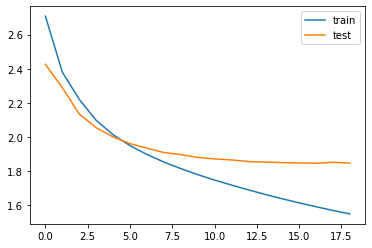

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현
* 테스트 단계에서는 정수 인덱스로 구성된 행렬을 실제 데이터로 복원해야하므로, 필요한 사전 3개를 아래와 같이 정의합니다.


* seq2seq는 훈련과 실제 동작(인퍼런스)의 방식이 다르므로 모델 설계를 별개로 진행해야 합니다.  
훈련 단계에서는 디코더의 입력부에 정답이 되는 문장을 넣고 출력과 비교할 수 있으므로, 인코더와 디코더를 엮은 모델 하나만 준비하면 됩니다.  
그러나 인퍼런스 단계에서는 정답 문장이 없기에 만들어야할 문장의 길이만큼 디코더가 반복적으로 동작해야 하기 때문에 어쩔 수 없이 인퍼런스를 위한 모델을 따로 설계해 주어야 합니다.

In [50]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [51]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [52]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [54]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : peanut butter lover keep house disappears way fast found powdered peanut butter heaven mix yogurt ice cream make peanut butter pie feel quite guilty totally enjoying flavor daughter law big fan peanut butter also peanut butter lovers highly recommend powdered peanut butter 
실제 요약 : powdered peanut butter 
예측 요약 :  pb is the best


원문 : little silver pouches ginger lover dream whether served hot cold crystals dissolve instantly slight hint lies store first sip ginger back throat make known overwhelming hint lemon drink strength ginger something people either enjoy taste like tea long adjust relative strength adding less water mix 
실제 요약 : all ginger 
예측 요약 :  strong taste


원문 : special needs pet searched right food since amazon five star resource chose pot pie shipped many cans dented toss return big hassle would ever feed dented beloved boy best purchase pet store evidently 
실제 요약 : caution dented cans 
예측 요약 :  dented cans


원문 : dogs loved recommend anyone small dogs small dogs

## 추출적 요약 해보기
* 앞서 seq2seq를 통해 추상적 요약을 진행했습니다.
* 이번엔 추상적 요약이 아닌 이미 본문에 존재하는 단어구, 문장을 뽑아 요약하는 추출적 요약을 사용해 볼 것입니다.  

* 패키지 summa에서는 추출적 요약을 위한 모듈인 summarize를 제공해 간단히 진행해 볼 수 있습니다.

* summarize 모듈을 사용해 매트릭스 시놉시스를 요약해보겠습니다.

In [55]:
import requests
from summa.summarizer import summarize

### 원문을 가져옵니다.

In [56]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [57]:
print(text[:1000])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and 


### summarize를 사용하여 원문을 요약합니다.
#### summarize에 사용되는 인자는 다음과 같습니다.
* text : 원문
* ratio : 요약문에서 원문에서 선택되는 문장 비율
* words : 출력에 포함할 단어 수
* split : 요약문을 리스트로 반환할지 문자열로 반환할지 결정

In [58]:
print('Summary:')
print(summarize(text, ratio=0.005))
print(summarize(text, ratio=0.005,split = True))
print(summarize(text, words = 50))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


-----------------------------------------------------------------------------------

# 프로젝트 : 뉴스 기사 요약하기
* 새로운 데이터셋에 대해 추상적 요약과 추출적 요약을 모두 해보도록 합시다.

## STEP 1. 데이터 수집하기

In [59]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [60]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## STEP 2. 데이터 전처리하기
* 위에서 정의한 전처리용 함수를 활용합니다.

In [61]:
# 텍스트 , 요약문 순으로 컬럼을 다시 정의합니다.
data = data[['text','headlines']]
data.head()

,text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


### 중복 데이터와 NULL을 제거합니다.

In [62]:
# 중복 데이터 개수 확인
print("전체 데이터의 개수 : ",data.shape[0])
print("중복된 text 데이터의 개수 :", data.nunique().text)

전체 데이터의 개수 :  98401
중복된 text 데이터의 개수 : 98360


In [63]:
# 중복 데이터 제거
data.drop_duplicates(subset = ['text'],inplace = True)
print("전체 데이터의 개수 :",data.shape[0])

전체 데이터의 개수 : 98360


In [64]:
# NULL 개수 확인
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


* 널값은 없네용 ㅎㅎ;;

In [65]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

In [66]:
clean_summary = []
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s,False))

In [67]:
# 정규화가 잘 되었는지 확인합니다.
print(len(clean_text))
print(clean_text[:3])
print(clean_summary[:3])

98360
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history']
['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma le

In [68]:
data['text'] = clean_text
data['headlines'] = clean_summary

In [69]:
# 정규화 후 null값이 생겼는지 확인합니다.
data.replace('',np.nan,inplace = True)
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


### 샘플의 최대 길이를 결정합니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


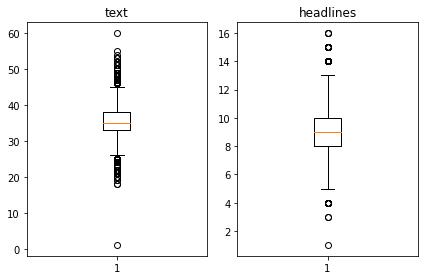

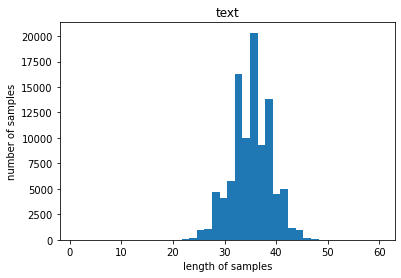

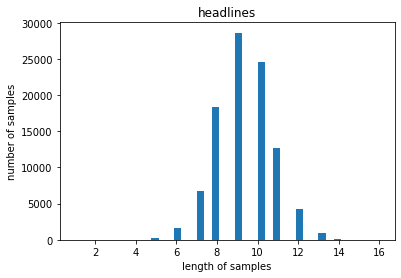

In [70]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [71]:
text_max_len = 40
summary_max_len = 10
below_threshold_len(text_max_len,data['text'])
below_threshold_len(summary_max_len,data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [72]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


### 요약본을 기반으로 시작 토큰과 끝 토큰을 추가합니다.

In [73]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll in rajasthan takes to...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,two minor cousins uttar pradesh gorakhpur alle...,up cousins fed human excreta for friendship wi...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [74]:
# 훈련데이터와 테스트 데이터를 분리합니다.
encoder_input_train,decoder_input_train,decoder_target_train,encoder_input_test,decoder_input_test,decoder_target_test = train_test_split(data)

In [75]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


In [76]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [77]:
rare_voca(src_tokenizer,7)

단어 집합(vocabulary)의 크기 : 61609
등장 빈도가 6번 이하인 희귀 단어의 수: 42289
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19320
단어 집합에서 희귀 단어의 비율: 68.64094531643104
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.191887349676271


In [78]:
src_vocab = 16000

In [79]:
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [80]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [81]:
print(encoder_input_train[:3])
print(encoder_input_test[:3])

[[258, 802, 42, 243, 916, 5890, 4162, 334, 842, 201, 2589, 1578, 1044, 258, 268, 42, 554, 3653, 1217, 42, 1386, 961, 176, 23, 280, 1325, 258, 107, 243], [5891, 15083, 143, 56, 815, 9230, 101, 15084, 6986, 10324, 41, 2444, 3654, 3232, 101, 1932, 183, 3, 330, 1, 10324, 4852, 943, 5891, 15083, 26, 816, 11, 11342, 157, 5663, 2120], [1089, 1121, 722, 165, 375, 5453, 2844, 223, 164, 236, 121, 862, 4201, 1260, 1089, 10, 164, 186, 10644, 722, 409, 68, 1, 1089, 6234, 5966, 845, 58, 6626, 2109, 7, 1375]]
[[12, 237, 520, 8218, 6558, 6941, 611, 236, 4922, 2818, 2863, 6570, 273, 481, 1648, 539, 3711, 25, 1, 237, 5, 274, 1431, 328, 698, 3089, 1445, 1814, 701, 1177, 3256, 4371, 913], [8020, 35, 116, 3798, 349, 154, 16, 3780, 1828, 1398, 2571, 2102, 530, 507, 131, 13689, 256, 2461, 1302, 714, 73, 2658, 90, 201, 2658, 33, 2, 3798, 1647, 586, 9482, 1114, 243], [2092, 77, 2047, 465, 82, 1, 1204, 541, 533, 4168, 1320, 803, 2582, 4443, 1270, 13566, 64, 465, 1, 803, 69, 566, 640, 89, 4, 1397, 4168, 1193, 53

In [82]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [83]:
rare_voca(tar_tokenizer,5)

단어 집합(vocabulary)의 크기 : 27312
등장 빈도가 6번 이하인 희귀 단어의 수: 19060
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8252
단어 집합에서 희귀 단어의 비율: 69.78617457527827
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.8196129501612


In [84]:
tar_vocab = 7000

In [85]:
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [86]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [87]:
print('input')
print('input ',decoder_input_train[:3])
print('target')
print('decoder ',decoder_target_train[:3])

input
input  [[1, 120, 963, 148, 3, 5, 67, 434, 515, 349], [1, 5393, 107, 2400, 4, 2796, 2401, 1890], [1, 892, 155, 244, 2865, 1025, 18, 510]]
target
decoder  [[120, 963, 148, 3, 5, 67, 434, 515, 349, 2], [5393, 107, 2400, 4, 2796, 2401, 1890, 2], [892, 155, 244, 2865, 1025, 18, 510, 2]]


In [88]:
#비어버린 문장은 시작토큰만 남아있을 것입니다. 따라서 길이 1의 문장을 모두 제거하도록 합니다.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14819
테스트 레이블의 개수 : 14819


### Zero padding하기
* 이번엔 pre padding을 사용해봅시다.

In [89]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='pre')

## STEP 3. 어텐션 메커니즘 사용하기
* 어텐션 메커니즘을 적용한 모델을 설계합니다.
* 인퍼런스 모델은 훈련된 모델의 출력 레이어를 교체해 사용합니다. 

In [90]:
embedding_dim = 128
hidden_size = 256

In [91]:
# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# 레이어를 선언하고 해당 레이어를 상위 레이어와 연결합니다.
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [92]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [93]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델을 새로 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2048000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [94]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [95]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 133s 541ms/step - loss: 5.9924 - val_loss: 5.6374
Epoch 2/50
232/232 [==============================] - 124s 535ms/step - loss: 5.6467 - val_loss: 5.5202
Epoch 3/50
232/232 [==============================] - 125s 537ms/step - loss: 5.4716 - val_loss: 5.5429
Epoch 4/50
232/232 [==============================] - 124s 535ms/step - loss: 5.2045 - val_loss: 5.2388
Epoch 5/50
232/232 [==============================] - 124s 536ms/step - loss: 4.9363 - val_loss: 4.8284
Epoch 6/50
232/232 [==============================] - 125s 537ms/step - loss: 4.7064 - val_loss: 4.6467
Epoch 7/50
232/232 [==============================] - 125s 537ms/step - loss: 4.5166 - val_loss: 4.5175
Epoch 8/50
232/232 [==============================] - 124s 534ms/step - loss: 4.3428 - val_loss: 4.4027
Epoch 9/50
232/232 [==============================] - 125s 538ms/step - loss: 4.1896 - val_loss: 4.5122
Epoch 10/50
232/232 [==============================] - 126s 544m

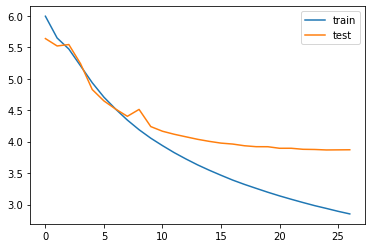

In [105]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 설계하기

In [96]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [97]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [98]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

## STEP 4. 실제 결과와 요약문 비교
* 대충 아무거나 뽑아서 비교해봅시다.

In [99]:
ran = np.arange(encoder_input_test.shape[0])
np.random.shuffle(ran)
for i in ran[:10]:
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : women child development ministry summoned air india cmd pradeep singh next week explain delay completing probe sexual harassment case complaint lodged air hostess senior airline executive describing predator air hostess alleged executive harassed last six years 
실제 요약 : govt summons air india over delay in harassment probe 
예측 요약 :  air india to air india harassment case against harassment


원문 : supreme court banned sale firecrackers delhi ncr till november city witnessed cleanest diwali thursday three years according central pollution control board data air quality index diwali year poor 
실제 요약 : delhi records diwali in yrs after sale ban 
예측 요약 :  ngt stays ngt stays of firecrackers in delhi ncr


원문 : west bengal government extended summer vacation government aided government sponsored schools june due heat wave hit several parts state state education minister partha chatterjee also appealed private schools avoid extreme heat 
실제 요약 : summer vacation extended in west bengal du

## STEP 5. Summa를 이용해서 추출적 요약 해보기
* Summa의 summarize 함수는 전처리와 토큰화까지 자체적으로 제공해줍니다.
* 따라서, 전처리 되지 않은 data를 다시 가져와 사용합니다.
* 또한, summarize는 정답 레이블이 필요없으므로 data에서 text만을 사용해 요약합니다.

In [100]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
#text열만을 남깁니다.
data_x = data['text'].apply(str)
#요약과 비교
data_y = data['headlines']

In [101]:
ran = np.arange(data_x.shape[0])
np.random.shuffle(ran)

for i in ran[:10]:
    print("original:")
    print(data_x[i],"\n")
    print("using summarize:")
    print(summarize(data_x[i], words = 15),"\n")
    print("original summary:")
    print(data_y[i],'\n') 

original:
Clarifying who he was appearing for in the Ayodhya dispute, senior advocate Kapil Sibal said, "I was appearing for petitioner Mohammad Hashmi's son Iqbal Hashmi, which is clearly stated in the order by the CJI." He further questioned, "Does PM think CJI order was wrong?" This comes amid reports that Sibal was representing the Sunni Waqf Board in the case.  

using summarize:
 

original summary:
Sibal clarifies who he was appearing for in Ayodhya case 

original:
UK-based ACWorldwide has developed a speaker based on Terminator films powered by Amazon's digital assistant Alexa. Priced at Ã¢ÂÂ¹32,000, the speaker is 18 inches tall and connects via Bluetooth, Wi-Fi, and AUX cable. It also lets users answer phone calls using internal microphone. The left eye of the skull is a high-definition camera which streams videos to the user's smartphone.  

using summarize:
Priced at Ã¢ÂÂ¹32,000, the speaker is 18 inches tall and connects via Bluetooth, Wi-Fi, and AUX cable. 

original s

# 회고합시다.
* 모델 설계에서 조금 헷갈렸지만 연결리스트와 비슷하다고 생각하니 이해가 쉬웠졌습니다.
* 프로젝트 모델에서 원문 자체가 상대적으로 짧다보니 요약문의 길이를 맞추기 위해 중복된 단어들이 들어가는 현상이 있었습니다.
* 비슷한 문제로 원문의 길이가 짧아 summarize 사용 시 요약문이 만들어지지 않았습니다.  이걸 해결하기위해 비율을 올리거나 고정된 words로 요약을 진행합니다.


* 종합적으로 추상적 요약이나 추출적 요약이나 양질의 요약문을 얻기 위해선 원문 데이터의 길이가 긴것이 좋다고 여겨집니다.